In [1]:
#practice with just one design.mat
import numpy as np
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_anat
from nilearn.image import math_img,  largest_connected_component_img
import nibabel as nib
import json
import glob
from scipy.stats import norm

# Function to threshold stat image
def mask_tstat_img(tstat_path, p_gt0_path, p_lt0_path):
    """Function for thresholding t-statistic map based on two 1-sided 
    1-p values maps.  Output is thresholded t-stat map
    tstat_path:  Path to t-stat image
    p_gt0_path:  Path to 1-p value image for contrast>0
    p_lt0_path:  Path to 1-p value image for contrast<0
    """
    tstat_img = nib.load(tstat_path)
    p_gt0_img = nib.load(p_gt0_path)
    p_lt0_img = nib.load(p_lt0_path)
    thresh_tstat_img = math_img('((img1>0.95)+(img2>0.95))*img3',
    img1=p_gt0_img, img2=p_lt0_img, img3=tstat_img)
    return thresh_tstat_img

def search_analysis_make_figures(taskname):
    """Function that loops through all analysis directories (randomise) within a task
    and finds contrasts involving RT as a covariate.  If no significant results, message 
    is output to screen.  Otherwise a thresholded t-stat map (p<0.05) is created.
    taskname: name of task.  One of ANT, CCTHot, DPX, WATT3, discountFix, motorSelective Stop,
    stopSignal, stroop and twoByTwo
    """

    analysis_dirs = glob.glob('/Users/jeanettemumford/sherlock_local/uh2/aim1/BIDS_scans/derivatives/2ndlevel_4_2_21/{0}/secondlevel-RT-True_beta-False_maps/*Randomise'.format(taskname))

    for current_directory in analysis_dirs:
        f = open(analysis_dirs[0] + '/t_name_map.json')
        tnames = json.load(f)
        f.close()
        search_key = 'RT'
        res = [key for key, val in tnames.items() if search_key in val]

        # should always be an even number of contrasts
        if len(res)%2 == 0:
            num_contrasts = len(res)//2
        else:
            print('skipping {0} since odd number of RT contrasts'.format(current_directory))
            continue

        for connum in range(num_contrasts):
            cont_ind1 = res[2*connum]
            cont_ind2 = res[2*connum + 1]

            dependent_variable_name = os.path.basename(current_directory)
            independent_variable_name = tnames[cont_ind1][:-3]

            # Threshold t-stat image
            tstat_path = "{0}/randomise_tstat{1}.nii.gz".format(current_directory, cont_ind1)
            p_gt0_path = "{0}/randomise_tfce_corrp_tstat{1}.nii.gz".format(current_directory, cont_ind1)
            p_lt0_path = "{0}/randomise_tfce_corrp_tstat{1}.nii.gz".format(current_directory, cont_ind2)
            thresh_tstat = mask_tstat_img(tstat_path, p_gt0_path, p_lt0_path)

            # Only create image if there are significant voxels
            sig_voxels = np.count_nonzero(thresh_tstat.get_fdata())

            if sig_voxels>0:
              stat_args = {'threshold': 0,
                 'cut_coords': 10,
                 'black_bg': True}  
              plot_stat_map(thresh_tstat, title="{0} correlated with {1}".format(dependent_variable_name, independent_variable_name), display_mode='z', **stat_args)  
            else:
                print('{0} has no significant correlation with {1}'.format(dependent_variable_name, independent_variable_name))

contrast-subsequent_RT_Randomise has no significant correlation with first_RT
contrast-subsequent_RT_Randomise has no significant correlation with subsequent_RT
contrast-trial_gain_Randomise has no significant correlation with first_RT
contrast-trial_gain_Randomise has no significant correlation with subsequent_RT
contrast-positive_draw_Randomise has no significant correlation with subsequent_RT
contrast-negative_draw_Randomise has no significant correlation with first_RT
contrast-negative_draw_Randomise has no significant correlation with subsequent_RT
contrast-trial_loss_Randomise has no significant correlation with first_RT
contrast-trial_loss_Randomise has no significant correlation with subsequent_RT


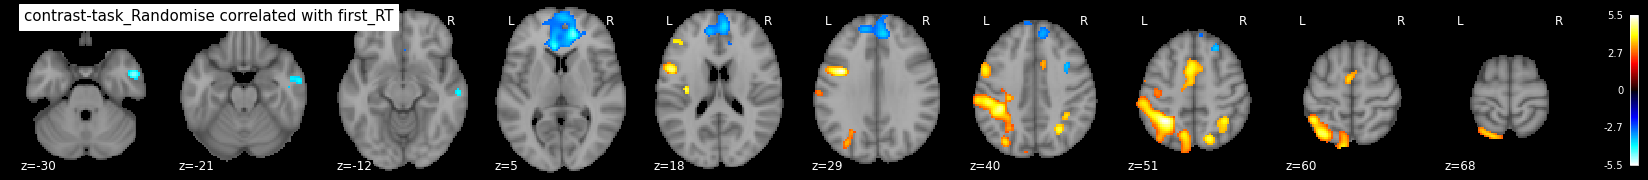

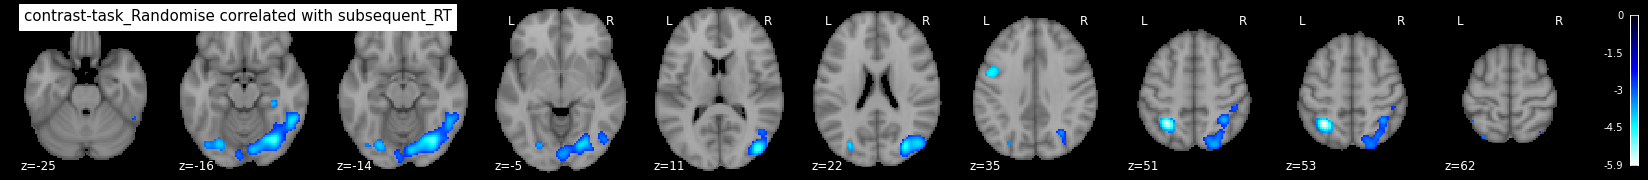

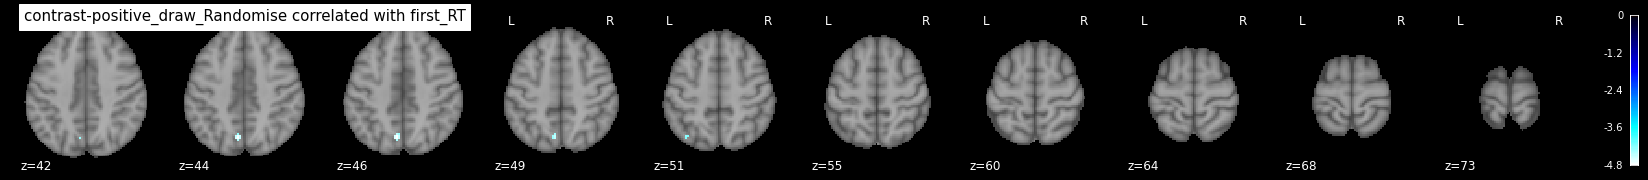

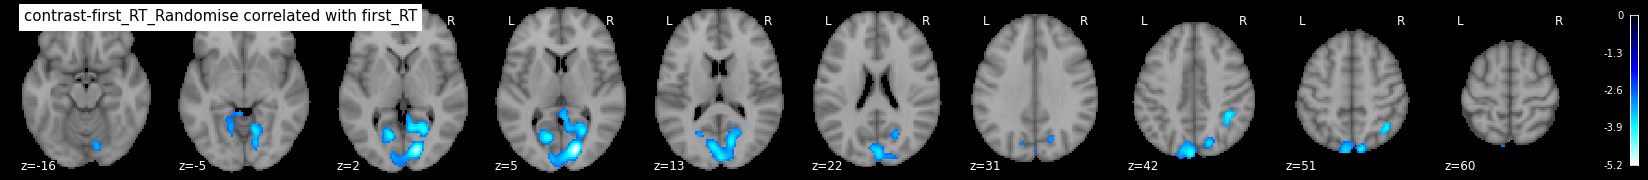

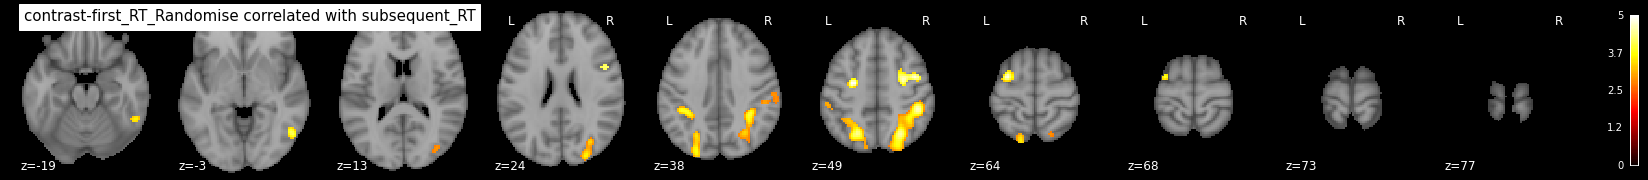

In [2]:
search_analysis_make_figures('CCTHot')